In [56]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./trajopt/scaling.jl")
include("./funlopt/funl_dynamics.jl")
include("./funlopt/funl_utils.jl")
include("./funlopt/funl_constraint.jl")

impose (generic function with 3 methods)

In [57]:
# Setting
type_funnel_dynamics = "Basic" # Basic, Lyapunov
type_nonlinearity = "Linear" # Linear Lipschitz Lsmooth
type_Z_parameterization = "FOH" # ZOH, FOH
type_funl_ctcs = false # true or false

false

In [58]:
# load nominal trajectory
using JLD2, FileIO
@load "./data/nominal_traj_unicycle_0324" my_dict
xnom = my_dict["x"]
unom = my_dict["u"]
tnom = my_dict["t"];
N = size(xnom,2) - 1
dtnom = zeros(N)
for i in 1:N
    dtnom[i] = tnom[i+1]-tnom[i]
end
@assert size(xnom,2) - 1 == N

In [59]:
function get_H_obs(rx,ry)
    return diagm([1/rx,1/ry])
end
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.5,0.5)
push!(c_list,c1)
push!(H_list,H1)
c2 = [4,3]
H2 = get_H_obs(0.5,0.5)
push!(c_list,c2)
push!(H_list,H2)

vmax = 2.0
vmin = 0.0
wmax = 2.0
wmin = -2.0
list_const = [InputConstraint([1;0],vmax),
    InputConstraint([-1;0],-vmin),
    InputConstraint([0; 1],wmax),
    InputConstraint([0; -1],-wmin),
    ObstacleAvoidance(H_list[1],c_list[1]),
    ObstacleAvoidance(H_list[2],c_list[2])
    ]

6-element Vector{FunnelConstraint}:
 InputConstraint([1, 0], 2.0)
 InputConstraint([-1, 0], -0.0)
 InputConstraint([0, 1], 2.0)
 InputConstraint([0, -1], 2.0)
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2])
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])

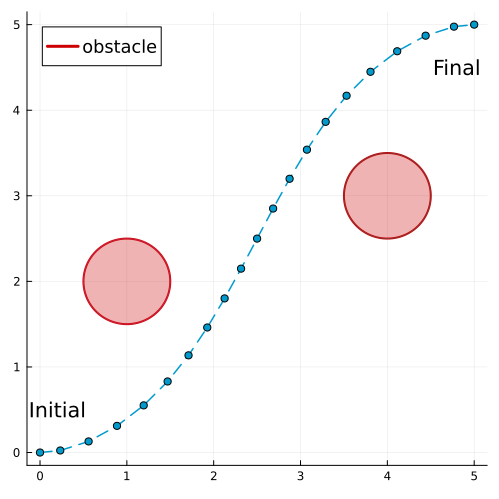

In [60]:
p2 = Plots.plot(; size=(500,500))
plot!(xnom[1,:],xnom[2,:],c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
scatter!(xnom[1,:],xnom[2,:],c=:deepskyblue3,linewidth=1.5,label=nothing)
for (idx,(ce, H)) in enumerate(zip(c_list, H_list))
    label = nothing
    if idx == 1
        label = "obstacle"
    end
    plot_ellipse(p2,inv(H)*inv(H),ce,"red3",label=label)
end
annotate!(0.2, 0.5, text("Initial", :black, :center))
annotate!(4.8, 4.5, text("Final", :black, :center))
display(p2)


In [61]:
dynamics = Unicycle()
alpha = 0.1
ix = size(xnom,1)
iu = size(unom,1)
DLMI = Basic_type(alpha,ix,iu,0)

Basic_type(0.1, 3, 2, 6, 6, 0, 6, 12, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1, 4, 5, 7, 8, 9], sparse([1, 2, 4, 5, 3, 7, 6, 8, 9], [1, 2, 2, 3, 4, 4, 5, 5, 6], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 9, 6))

In [62]:
Qnom = zeros(ix,ix,N+1)
Ynom = zeros(iu,ix,N+1)
ZLnom = zeros(ix,ix,N);
ZRnom = zeros(ix,ix,N);
Qini = diagm([0.08,0.08,0.06])
Qf = diagm([0.08,0.08,0.06])
for i in 1:N+1
    Qnom[:,:,i] .= Qini
end
Xnom,ULnom,URnom = QYZ_to_XULR(Qnom,Ynom,ZLnom,ZRnom);

In [63]:
xmin = [0;0;0];
xmax = [5;5;pi];
umin = [0;0];
umax = [vmax;wmax];
scaler = Scaling(xmin, xmax, umin, umax, tnom[end],0,0)

Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 5.0, 0.0, 0.0, 0.0)

In [81]:
include("./funlopt/funl_synthesis.jl")
include("./funlopt/funl_utils.jl")

propagate_from_funnel_entry (generic function with 1 method)

In [82]:
max_iter = 1;
w_funl = 1.0;
w_vc = 1e2;
w_tr::Float64 = 0.00
tol_vc = 1e-6;
tol_tr = 1e-4;
tol_dyn = 1e-1;
verbosity = 0;

In [83]:
fs = FunnelSynthesis(N,max_iter,dynamics,DLMI,list_const,scaler,
    w_funl,w_vc,w_tr,tol_tr,tol_vc,tol_dyn,verbosity)

FunnelSynthesis(Unicycle(3, 2, 2, 2, 2, 2, [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [1 0; 0 1; 0 0], [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [0.0, 0.0]), Basic_type(0.1, 3, 2, 6, 6, 0, 6, 12, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1, 4, 5, 7, 8, 9], sparse([1, 2, 4, 5, 3, 7, 6, 8, 9], [1, 2, 2, 3, 4, 4, 5, 5, 6], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 9, 6)), FunnelConstraint[InputConstraint([1, 0], 2.0), InputConstraint([-1, 0], -0.0), InputConstraint([0, 1], 2.0), InputConstraint([0, -1], 2.0), ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2]), ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])], Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 5.0, 0.0, 0.0, 0.0), FunnelSolution([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0

In [84]:
run(fs,Xnom,ULnom,URnom,Qini,Qf,xnom,unom,dtnom,"Mosek")

|1      |-2.94       |-1.000    |-2.937     |-1.000     |-1.000    |-Inf     | 0.3      |-7.4e+00   |


In [85]:
tprop,xprop,uprop = fs.solution.tprop,fs.solution.xprop,fs.solution.uprop
Xprop,Uprop = fs.solution.Xprop,fs.solution.Uprop
Qprop,Yprop,Zprop = XU_to_QYZ(Xprop,Uprop,ix,iu)
Qnode,Ynode,ZLnode,ZRnode = XULR_to_QYZ(fs.solution.X,fs.solution.UL,fs.solution.UR,ix,iu)

([6.702513046242702 -1.444613713831436 2.6404484861915747; -1.444613713831436 3.5364001052840646 -2.474281246397199; 2.6404484861915747 -2.474281246397199 3.0385633655260724;;; 5.967670770699703 -0.8760839506707251 2.474424798883733; -0.8760839506707251 2.661040733852565 -1.8430322587653598; 2.474424798883733 -1.8430322587653598 2.680298543514561;;; 5.0707959336248525 -0.18914953366676102 2.1504077148708047; -0.18914953366676102 1.8409932872272858 -1.1750176514662158; 2.1504077148708047 -1.1750176514662158 2.252745407051306;;; … ;;; 0.21779264884576632 0.09688525174740475 -0.15083516832682275; 0.09688525174740475 0.13413684728959932 -0.16311547922193553; -0.15083516832682275 -0.16311547922193553 0.26305820014838616;;; 0.14132589590950098 0.02553623694774854 -0.06570477815720766; 0.02553623694774854 0.0773627088208915 -0.07802119027832231; -0.06570477815720766 -0.07802119027832231 0.12584072257807083;;; 0.07964370803454299 0.00015884527839918824 -0.0002691225106326648; 0.000158845278399

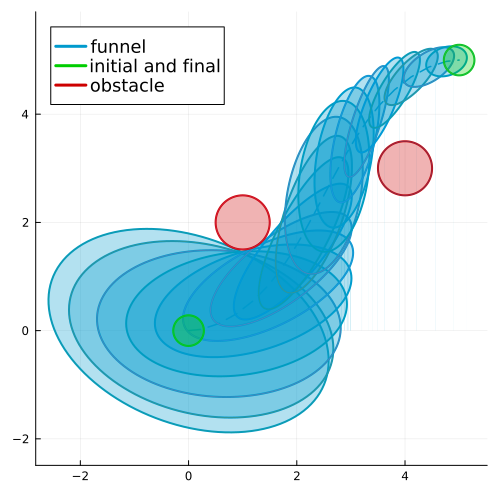

In [86]:
p2 = Plots.plot(; size=(500,500))
plot!(xnom[1,:],xnom[2,:],aspect_ratio=:equal,c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
for idx in 1:N
    label = nothing
    if idx == 1
        label = "funnel"
    end
    plot_ellipse(p2,Qnode[:,:,idx],xnom[:,idx],"deepskyblue3",label=label)
end
plot_ellipse(p2,fs.solution.Qi,xnom[:,1],"green3",label="initial and final")
plot_ellipse(p2,fs.solution.Qf,xnom[:,end],"green3")
for (idx,(ce, H)) in enumerate(zip(c_list, H_list))
    label = nothing
    if idx == 1
        label = "obstacle"
    end
    plot_ellipse(p2,inv(H)*inv(H),ce,"red3",label=label)
end
display(p2)

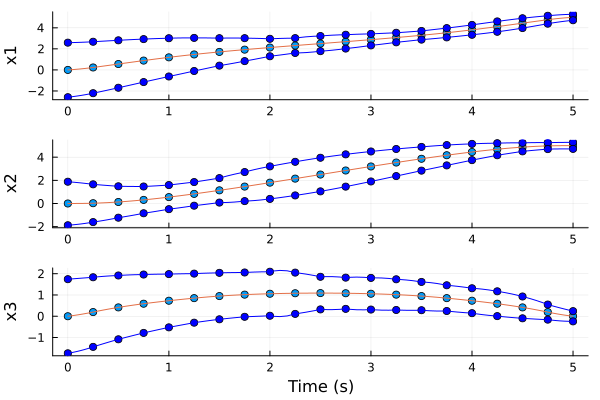

In [87]:
p = []
for idx in 1:3
    push!(p,plot(tnom,xnom[idx,:],seriestype = :scatter,label=""))
    plot!(tprop,xprop[idx,:],label="")
    plot!(tnom,xnom[idx,:] + sqrt.(Qnode[idx,idx,:]),color=:blue,seriestype = :scatter,label="")
    plot!(tprop,xprop[idx,:] + sqrt.(Qprop[idx,idx,:]),color=:blue,label="")
    plot!(tnom,xnom[idx,:] - sqrt.(Qnode[idx,idx,:]),color=:blue,seriestype = :scatter,label="")
    plot!(tprop,xprop[idx,:] - sqrt.(Qprop[idx,idx,:]),color=:blue,label="")
    if idx == 3
        xlabel!("Time (s)")
    end
    ylabel!("x" * string(idx))
end
plot(p[1],p[2],p[3],layout=(3,1))

# Input funnel

In [88]:
function project_onto_input(Q,Y) 
    R = []
    for i in 1:size(Q,3)
        K = Y[:,:,i] * inv(Q[:,:,i])
        push!(R,K*Q[:,:,i]*K')
    end
    projected_input_funl = []
    for j in 1:iu
        a = zeros(iu)
        a[j] = 1
        each_funl = []
        for i in 1:length(R)
            push!(each_funl,sqrt(a'*R[i]*a))
        end
        push!(projected_input_funl,each_funl)
    end
    return projected_input_funl
end
input_proj_funl_prop = project_onto_input(Qprop,Yprop)
input_proj_funl_nom = project_onto_input(Qnode,Ynode)

2-element Vector{Any}:
 Any[0.5831408867990728, 0.7055146697396557, 0.5437037663319487, 0.459472329250808, 0.419818322336887, 0.4396051273940521, 0.4490422473022427, 0.42762932947731175, 0.4174792027451205, 0.4132516033351376  …  0.41331953552109535, 0.41747049079645787, 0.4273775262467733, 0.4486418320593972, 0.43897904282256756, 0.41802239492067983, 0.4573000814008485, 0.5425858484018871, 0.7060647148675302, 0.5817549394800584]
 Any[0.8916019342610325, 1.0115134778792696, 1.2281827264063208, 1.3895315298653979, 1.4832304781521357, 1.5466563588875013, 1.6731606557877352, 1.787875773298862, 1.8726365755679462, 1.9358369662341501  …  1.9264227620520453, 1.8547967042374853, 1.763687815413649, 1.6454554962054275, 1.502956730122536, 1.4606831277283978, 1.3757053030053727, 1.2152482493514603, 0.988780402545722, 1.4242682019448403]

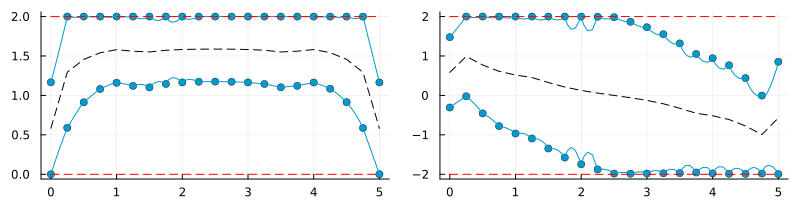

In [89]:
p1 = plot(tnom,unom[1,:],linestyle=:dash,color="black",label="")
scatter!(tnom,unom[1,:]+input_proj_funl_nom[1],color="deepskyblue3",label="")
scatter!(tnom,unom[1,:]-input_proj_funl_nom[1],color="deepskyblue3",label="")
plot!(tprop,uprop[1,:]+input_proj_funl_prop[1],color="deepskyblue3",label="")
plot!(tprop,uprop[1,:]-input_proj_funl_prop[1],color="deepskyblue3",label="")
plot!(tnom,tnom*0 .+ vmax,linestyle=:dash,color="red",label="")
plot!(tnom,tnom*0 .+ vmin,linestyle=:dash,color="red",label="")
p2 = plot(tnom,unom[2,:],linestyle=:dash,color="black",label="")
scatter!(tnom,unom[2,:]+input_proj_funl_nom[2],color="deepskyblue3",label="")
scatter!(tnom,unom[2,:]-input_proj_funl_nom[2],color="deepskyblue3",label="")
plot!(tprop,uprop[2,:]+input_proj_funl_prop[2],color="deepskyblue3",label="")
plot!(tprop,uprop[2,:]-input_proj_funl_prop[2],color="deepskyblue3",label="")
plot!(tnom,tnom*0 .+ wmax,linestyle=:dash,color="red",label="")
plot!(tnom,tnom*0 .+ wmin,linestyle=:dash,color="red",label="")
plot(p1,p2,layout=(1,2),size=(800,200))

# Check CTCS

### Q $\succ$ 0

In [90]:
min_lam_qprop = zeros(size(Qprop,3))
for i in 1:size(Qprop,3)
    eigvals = eigen(Qprop[:,:,i]).values
    min_lam_qprop[i] = eigvals[1]
end
min_lam_q = zeros(size(Qnode,3))
for i in 1:size(Qnode,3)
    eigvals = eigen(Qnode[:,:,i]).values
    min_lam_q[i] = eigvals[1]
end

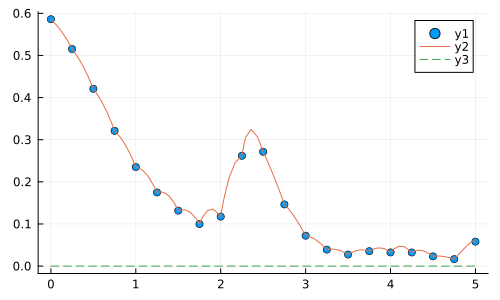

In [91]:
scatter(tnom,min_lam_q,seriestype="o",size=(500,300))
plot!(tprop,min_lam_qprop)
plot!(tnom,tnom .* 0,linestyle=:dash)

In [92]:
findfirst(x -> x < 0, min_lam_q)

### Invariance

In [93]:
Cprop = zeros(1, size(Qprop,3))
CLnode = zeros(1, size(Qnode,3)-1)
CRnode = zeros(1, size(Qnode,3)-1)
for i in 1:size(Cprop,2)
    G = - invariance_condition(fs,Qprop[:,:,i],Yprop[:,:,i],Zprop[:,:,i],xprop[:,i],uprop[:,i])
    eigvals = eigen(G).values
    Cprop[1,i] = eigvals[end]
end
for i in 1:size(CLnode,2)
    GL = - invariance_condition(fs,Qnode[:,:,i],Ynode[:,:,i],ZLnode[:,:,i],xnom[:,i],unom[:,i])
    eigvals = eigen(GL).values
    CLnode[1,i] = eigvals[end]
end
for i in 1:size(CRnode,2)
    GR = - invariance_condition(fs,Qnode[:,:,i+1],Ynode[:,:,i+1],ZRnode[:,:,i],xnom[:,i+1],unom[:,i+1])
    eigvals = eigen(GR).values
    CRnode[1,i] = eigvals[end]
end

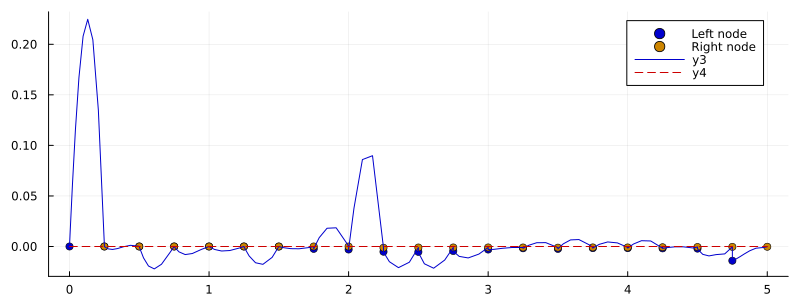

In [94]:
p = scatter(tnom[1:end-1],CLnode[1,:],seriestype="o",color="blue3",label="Left node",size=(800,300))
scatter!(p,tnom[2:end],CRnode[1,:],seriestype="o",color="orange3",label="Right node")
plot!(p,tprop,Cprop[1,:],color="blue3")
plot!(p,tnom,tnom .* 0,linestyle=:dash,color="red3")
display(p)

### Other constraints

In [95]:
N_constraint = size(fs.funl_constraint,1)
Cprop = zeros(N_constraint,size(Qprop,3))
Cnode = zeros(N_constraint,size(Qnode,3))
for j in 1:N_constraint
    for i in 1:size(Cprop,2)
        G = - impose(fs.funl_constraint[j],Qprop[:,:,i],Yprop[:,:,i],xprop[:,i],uprop[:,i],idx=i)
        eigvals = eigen(G).values
        Cprop[j,i] = eigvals[end]
    end
    for i in 1:size(Cnode,2)
        G = - impose(fs.funl_constraint[j],Qnode[:,:,i],Ynode[:,:,i],xnom[:,i],unom[:,i],idx=i)
        eigvals = eigen(G).values
        Cnode[j,i] = eigvals[end]
    end
end

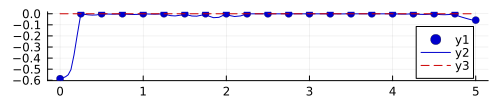

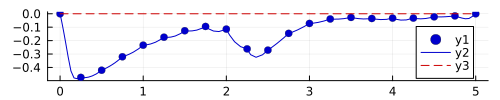

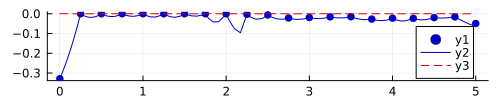

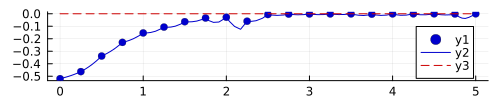

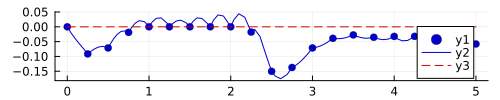

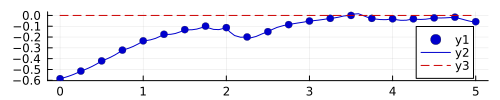

In [96]:
for idx in 1:N_constraint
    # Plots.plot(; size=(500,200))
    p = scatter(tnom,Cnode[idx,:],seriestype="o",color="blue3",size=(500,100))
    plot!(p,tprop,Cprop[idx,:],color="blue3")
    plot!(p,tnom,tnom .* 0,linestyle=:dash,color="red3")
    display(p)
end